In [224]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [225]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [226]:
function read_from_hdf5(h5file,obs_name)
	fid = h5open(h5file,"r")
	temps = fid["temperatures"][:]
	obs   = fid[obs_name*"/mean"]
	times = [i for i in 1:size(obs)[1]]
	return temps,obs,times
end

read_from_hdf5 (generic function with 1 method)

In [227]:
h5file = "2d_out.h5"
obs_name = "mq_sqrt3_corr"
temps,m_data,times = read_from_hdf5(h5file,obs_name)

([0.11, 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12], HDF5.Dataset: /mq_sqrt3_corr/mean (file: 2d_out.h5 xfer_mode: 0), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  19992, 19993, 19994, 19995, 19996, 19997, 19998, 19999, 20000, 20001])

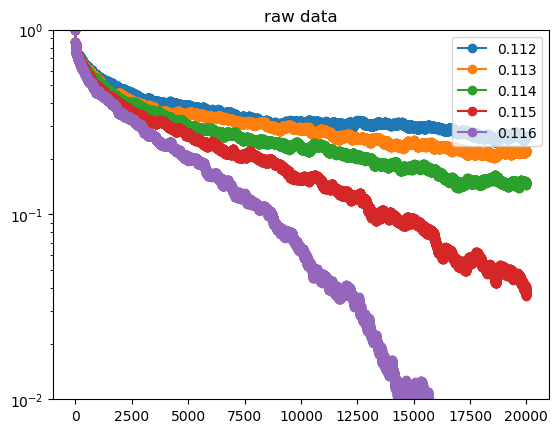

In [228]:
# cut too low temperature datas
num_temps = length(temps)
min_temp  = 3
max_temp  = 7
for it in min_temp:max_temp
	plt.semilogy(times,m_data[:,it],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-2,1)
plt.legend(loc="upper right")
plt.show()

In [229]:
#load average data from text file
temps = [0.112,0.113,0.114,0.115,0.116]
file_idx = [3,4,5,6,7]
num_temps = length(temps)
mc_steps  = 20000 
m_data = Array{Float64}(undef,mc_steps,num_temps)
counter = 1
for ifl in file_idx
	open("mq_sqrt3_$(ifl).dat","r") do fp
		for is in 1:mc_steps
			str = split(readline(fp))
			m_data[is,counter] = parse(Float64,str[2])
		end
	end
	counter += 1
end

In [230]:
m_data

20000×5 Array{Float64,2}:
 1.0       1.0       1.0       1.0        1.0
 0.859201  0.857849  0.856355  0.855727   0.853933
 0.838223  0.836014  0.834225  0.833295   0.831125
 0.829544  0.82749   0.824942  0.822893   0.819831
 0.822698  0.820562  0.818068  0.814607   0.811949
 0.816966  0.815283  0.813439  0.809022   0.806965
 0.813439  0.812433  0.809062  0.805366   0.802703
 0.810258  0.806497  0.806161  0.800641   0.799024
 0.806869  0.803237  0.801797  0.7987     0.794577
 0.80361   0.800982  0.799076  0.795108   0.792384
 0.802988  0.799993  0.7949    0.792642   0.788967
 0.799455  0.797118  0.79237   0.791105   0.787426
 0.797604  0.795111  0.790249  0.789043   0.782528
 ⋮                                        
 0.263932  0.221569  0.147425  0.0372743  0.00216053
 0.264149  0.222381  0.14829   0.0371697  0.0021565
 0.264439  0.221603  0.147944  0.0373267  0.00208419
 0.264394  0.221992  0.147996  0.0373466  0.00211701
 0.264924  0.221803  0.148182  0.0371703  0.00211249
 0.264747

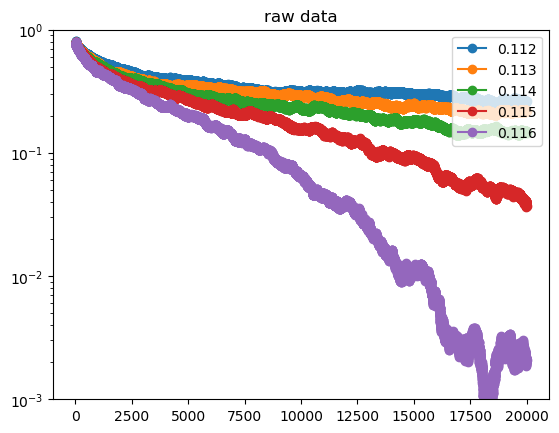

5


In [231]:
num_temps = length(temps)
println(num_temps)
times = [i for i in 1:size(m_data)[1]]
for it in 1:num_temps
	plt.semilogy(times[10:end],m_data[:,it][10:end],marker="o",label="$(temps[it])")
end
plt.title("raw data")
plt.ylim(1e-3,1)
plt.legend(loc="upper right")
plt.show()

In [232]:
# reshape some datas for optimization.
min_temp = 1
max_temp = 5
temps  = temps[min_temp:max_temp]
num_temps = length(temps)
m_data = m_data[:,min_temp:max_temp]


20000×5 Array{Float64,2}:
 1.0       1.0       1.0       1.0        1.0
 0.859201  0.857849  0.856355  0.855727   0.853933
 0.838223  0.836014  0.834225  0.833295   0.831125
 0.829544  0.82749   0.824942  0.822893   0.819831
 0.822698  0.820562  0.818068  0.814607   0.811949
 0.816966  0.815283  0.813439  0.809022   0.806965
 0.813439  0.812433  0.809062  0.805366   0.802703
 0.810258  0.806497  0.806161  0.800641   0.799024
 0.806869  0.803237  0.801797  0.7987     0.794577
 0.80361   0.800982  0.799076  0.795108   0.792384
 0.802988  0.799993  0.7949    0.792642   0.788967
 0.799455  0.797118  0.79237   0.791105   0.787426
 0.797604  0.795111  0.790249  0.789043   0.782528
 ⋮                                        
 0.263932  0.221569  0.147425  0.0372743  0.00216053
 0.264149  0.222381  0.14829   0.0371697  0.0021565
 0.264439  0.221603  0.147944  0.0373267  0.00208419
 0.264394  0.221992  0.147996  0.0373466  0.00211701
 0.264924  0.221803  0.148182  0.0371703  0.00211249
 0.264747

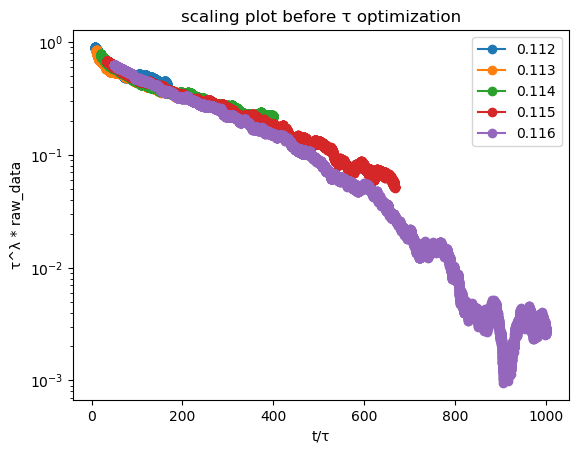

In [244]:
# search configuration of tau which put some curves on one curve.
taus   = [120,95.,50.,30.,20.0]
@assert length(taus) == max_temp - min_temp + 1
lambda = 0.1
start  = 1000
plt.figure()
for it in 1:num_temps
	plt.semilogy(times[start:end] ./ taus[it],(taus[it]^lambda)*m_data[:,it][start:end],marker="o",label="$(temps[it])")
	
end
plt.title("scaling plot before τ optimization")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * raw_data")
plt.legend(loc="upper right")
plt.show()

In [245]:
"""
params: [tau1, tau2, ...]
"""
newaxis = [CartesianIndex()]
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[start] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost (generic function with 1 method)

In [246]:
res = Optim.optimize(cost, taus)
res

 * Status: success

 * Candidate solution
    Final objective value:     4.550944e-03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    204
    f(x) calls:    424


In [247]:
taus_opt = Optim.minimizer(res)

5-element Array{Float64,1}:
 154.5075889792575
  77.88427323153367
  46.7046423982427
  31.414788303782586
  22.35537567578011

In [248]:
println("T τ")
for i in 1:num_temps 
	println(temps[i]," ",taus_opt[i])
end


T τ
0.112 154.5075889792575
0.113 77.88427323153367
0.114 46.7046423982427
0.115 31.414788303782586
0.116 22.35537567578011


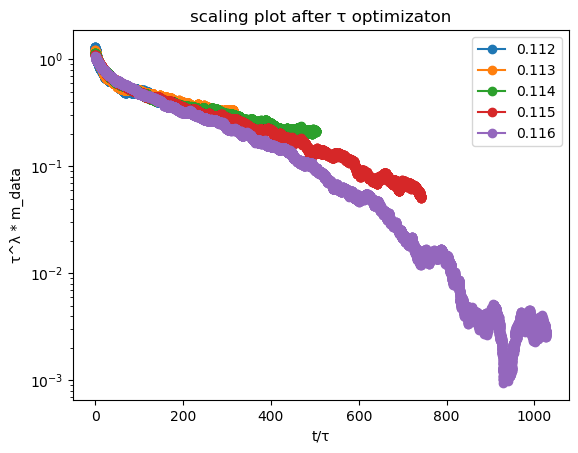

In [238]:
plt.figure()
for it in eachindex(temps)
	plt.semilogy(times[10:end] ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it][10:end], marker="o",label="$(temps[it])")
    #println((taus[it]^lambda) * m_data[:, it])
end
plt.title("scaling plot after τ optimizaton")
plt.xlabel("t/τ")
plt.ylabel("τ^λ * m_data")
plt.legend(loc="upper right")
plt.show()

In [239]:
x = 1.0
y = 0.9
n = 100
test = range(x,y,length=n)

1.0:-0.00101010101010101:0.9

In [240]:
test = LinRange(x,y,n)


100-element LinRange{Float64}:
 1.0,0.99899,0.99798,0.99697,0.99596,…,0.90404,0.90303,0.90202,0.90101,0.9